# 프로젝트 개요
- 강의명 : 2022년 K-디지털 직업훈련(Training) 사업 - AI데이터플랫폼을 활용한 빅데이터 분석전문가 과정
- 교과목명 : 빅데이터 분석 및 시각화, AI개발 기초, 인공지능 프로그래밍
- 프로젝트 주제 : FashionMNIST Data를 사용한 CNN모델 구축
- 프로젝트 마감일 : 2022년 4월 12일 화요일
- 강사명 : 정지훈 강사
- 수강생명 : 장민지

### MLP tutorial

In [46]:
!pwd

/home/jmj3047/mj_CNN_tutorial


In [ ]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [27]:
import os
import sys
from datetime import datetime
drive_project_root = "/home/jmj3047/mj_CNN_tutorial"
sys.path.append(drive_project_root) #경로 맞춰주기

In [ ]:
!pip install -r "requirements.txt"

In [ ]:
!pip install torchvision

In [28]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from omegaconf import DictConfig

import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch_optimizer import RAdam
from torch_optimizer import AdamP
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import random_split
from torchvision.datasets import FashionMNIST
from torchvision import transforms
import wandb

In [29]:
# 데이터 불러오기
data_root = os.path.join(os.getcwd(), 'data')

#preprocessing & 데이터 셋 정의
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5]), #mean, std
    ]
)
fashion_mnist_dataset = FashionMNIST(data_root, download=True, train=True, transform=transform)

In [30]:
fashion_mnist_dataset[0] #리스트 형태로 나옴
fashion_mnist_dataset[0][1] #레이블 번호가 나옴

9

In [ ]:
#split을 써야 함
#random_split을 사용해서 데이터를 나눌수 있음
from torch.utils.data import random_split

In [ ]:
data = random_split(
    fashion_mnist_dataset,
    [int(len(fashion_mnist_dataset)*0.7), len(fashion_mnist_dataset)-int(len(fashion_mnist_dataset)*0.7)
    ]
)

In [ ]:
data[0]

In [31]:
#위에서는 랜덤으로 split되는 거기 때문에 일정사이즈에 맞춰서 예측할수 있게끔 코드 짜주심
from data_utils import dataset_split

In [32]:
#DataLoader 정의

datasets = dataset_split(fashion_mnist_dataset,split=[0.9,0.1])
#이렇게 하면 train과 val 세트가 나눠짐

train_dataset = datasets["train"]
val_dataset = datasets["val"]

#미니배치: 한번에 얼마나 적용/업데이트 할 것인지 
train_batch_size = 100
val_batch_size = 10

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size = train_batch_size, shuffle = True, num_workers = 1
    #num_workers: 병렬 프로세싱 할 때 얼마나 있는게 좋은지, gpu연산 시 활용
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size = val_batch_size, shuffle = True, num_workers = 1
)

In [33]:
#샘플 배치가 어떻게 생겼는지
for sample_batch in train_dataloader:
    print(sample_batch)
    print(sample_batch[0].shape, sample_batch[1].shape)
    break

[tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        ...,


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1.,

In [34]:
# MLP 모델 정의
import torch.nn.functional as F

#Define Model.

class MLP(nn.Module): #이거 안하면 cpu, gpu에서 꼬임
    def __init__(self, in_dim:int, h1_dim: int, h2_dim:int, out_dim:int):
        super().__init__()
        self.linear1 = nn.Linear(in_dim, h1_dim)
        self.linear2 = nn.Linear(h1_dim, h2_dim)
        self.linear3 = nn.Linear(h2_dim, out_dim)
        self.relu = F.relu #활성화 함수 정의
    
    def forward(self, input):
        x = torch.flatten(input, start_dim=1) 
        #데이터 사이즈가 100,1,28,28인데 함수의 인풋은 다차원을 받아들일 준비가 안돼있음. 따라서 flatten을 해주면 100만 빼고 나머지가 flatten됨
        x = self.relu(self.linear1(x)) #첫번째 은닉층
        x = self.relu(self.linear2(x)) #두번째 은닉층
        out = self.linear3(x)
        #여기다 시그모이드,소프트 맥스 정의 가능
        # out = F.sigmoid(out)
        return out


#MLP + basic regularizers(Dropout, early stoppig)
class MLPWithDropout(MLP):
    def __init__(self, in_dim:int, h1_dim: int, h2_dim:int, out_dim:int, dropout_prob:float):
        super().__init__(in_dim, h1_dim, h2_dim, out_dim)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.dropout2 = nn.Dropout(dropout_prob)

    def forward(self, input):
        x = torch.flatten(input, start_dim=1) 
        x = self.relu(self.linear1(x)) #첫번째 은닉층
        x = self.dropout1(x)
        x = self.relu(self.linear2(x)) #두번째 은닉층
        x = self.dropout2(x)
        out = self.linear3(x)
        # out = F.sigmoid(out)
        return out


In [35]:
#CNN 모델 정의
_cnn_cfg_dict: dict = {
    "layer_1": {
        "conv2d_in_channels": 1,
        "conv2d_out_channels": 32,
        "conv2d_kernel_size": 3,
        "conv2d_padding": 1,
        "maxpool2d_kernel_size": 2,
        "maxpool2d_stride": 2,
    },
    "layer_2": {
        "conv2d_in_channels": 32,
        "conv2d_out_channels": 64,
        "conv2d_kernel_size": 3,
        "conv2d_padding": 0,
        "maxpool2d_kernel_size": 2,
        "maxpool2d_stride": 1,
    },
    "fc_1": {
        "in_features": 2304, #  수정 필요!
        "out_features": 512,
    },
    "fc_2": {
        "in_features": 512,
        "out_features": 128,        
    },
    "fc_3": {
        "in_features": 128,
        "out_features": 10,
    },
    "dropout_prob": 0.25,
}
_cnn_cfg = OmegaConf.create(_cnn_cfg_dict)
print(OmegaConf.to_yaml(_cnn_cfg))

class CNN(nn.Module):
    def __init__(self, cfg: DictConfig = _cnn_cfg):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(
                in_channels=cfg.layer_1.conv2d_in_channels,
                out_channels=cfg.layer_1.conv2d_out_channels,
                kernel_size=cfg.layer_1.conv2d_kernel_size,
                padding=cfg.layer_1.conv2d_padding
            ),
            nn.BatchNorm2d(cfg.layer_1.conv2d_out_channels),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=cfg.layer_1.maxpool2d_kernel_size,
                stride=cfg.layer_1.maxpool2d_stride
            )
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(
                in_channels=cfg.layer_2.conv2d_in_channels,
                out_channels=cfg.layer_2.conv2d_out_channels,
                kernel_size=cfg.layer_2.conv2d_kernel_size,
                padding=cfg.layer_2.conv2d_padding
            ),
            nn.BatchNorm2d(cfg.layer_2.conv2d_out_channels),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=cfg.layer_2.maxpool2d_kernel_size,
                stride=cfg.layer_2.maxpool2d_stride
            )
        )
        self.fc1 = nn.Linear(
            in_features=cfg.fc_1.in_features,
            out_features=cfg.fc_1.out_features,
        )
        self.fc2 = nn.Linear(
            in_features=cfg.fc_2.in_features,
            out_features=cfg.fc_2.out_features,
        )
        self.fc3 = nn.Linear(
            in_features=cfg.fc_3.in_features,
            out_features=cfg.fc_3.out_features,
        )
        self.dropout = nn.Dropout2d(cfg.dropout_prob)


    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

layer_1:
  conv2d_in_channels: 1
  conv2d_out_channels: 32
  conv2d_kernel_size: 3
  conv2d_padding: 1
  maxpool2d_kernel_size: 2
  maxpool2d_stride: 2
layer_2:
  conv2d_in_channels: 32
  conv2d_out_channels: 64
  conv2d_kernel_size: 3
  conv2d_padding: 0
  maxpool2d_kernel_size: 2
  maxpool2d_stride: 1
fc_1:
  in_features: 2304
  out_features: 512
fc_2:
  in_features: 512
  out_features: 128
fc_3:
  in_features: 128
  out_features: 10
dropout_prob: 0.25



In [36]:
# Learning rate scheduler
# Warmup Scheduler
class WarmupLR(optim.lr_scheduler.LambdaLR):

    def __init__(
        self,
        optimizer: optim.Optimizer,
        warmup_end_steps: int,
        last_epoch: int = -1,
    ):
        
        def wramup_fn(step: int):
            if step < warmup_end_steps:
                return float(step) / float(max(warmup_end_steps, 1))
            return 1.0
        
        super().__init__(optimizer, wramup_fn, last_epoch)



In [37]:
#모델 선언 및 손실함수 정의, optimizer 정의, logger(tensorboard) 정의

# # gpu setup
gpu = None
#gpu = 0
# gpu = os.environ["CUDA_VISIBLE_DEVICES"]=3

#define model
#model = MLP(28*28, 128, 64, 10)
model = MLPWithDropout(28*28, 128, 64, 10, dropout_prob=0.3)
model_name = type(model).__name__ #모델을 먼저 선언해주면 어떤모델로 사용하는지 보여줌
print(model_name)

#data loss
loss_function = nn.CrossEntropyLoss()

#define optimizer
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# optimizer = RAdam(model.parameters(), lr=lr)
# optimizer = AdamP(model.parameters(), lr=lr)
optimizer_name = type(optimizer).__name__

# define scheduler
scheduler = WarmupLR(optimizer, 1500)
scheduler_name = type(scheduler).__name__ if scheduler is not None else "no"

max_epoch = 10

#define tensorboard logger
run_name = f"{datetime.now().isoformat(timespec='seconds')}-{model_name}-{optimizer_name}_optim_{lr}_lr_with_{scheduler_name}_scheduler"
run_dirname = "dnn-tutorial-fashion-mnist-runs"
log_dir = os.path.join(drive_project_root, "runs", run_dirname, run_name)
writer = SummaryWriter(log_dir=log_dir)

#log interval
log_interval = 100 #100번마다 찍음

# define wandb
project_name = "fastcampus_fashion_mnist_tutorials"
run_tags = [project_name]
wandb.init(
    project=project_name,
    name=run_name,
    tags=run_tags,
    config={"lr": lr, "model_name": model_name, "optimizer_name": optimizer_name, "scheduler_name": scheduler_name},
    reinit=True,
)

# set save model path
log_model_path = os.path.join(log_dir, "models")
os.makedirs(log_model_path, exist_ok=True)

MLPWithDropout


In [ ]:
!pip install wandb --upgrade

In [38]:
## Early Stopping callback Object Class 정의

# With some modifications, source is from https://github.com/Bjarten/early-stopping-pytorch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.ckpt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.ckpt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        
        filename = self.path.split('/')[-1]
        save_dir = os.path.dirname(self.path)
        torch.save(model, os.path.join(save_dir, f"val_loss-{val_loss}-{filename}"))
        self.val_loss_min = val_loss

In [39]:
#logging 하는 방법
%load_ext tensorboard 
#외부에서 텐서보드를 가지고 온다
%tensorboard --logdir runs/ 
#runs라는 폴더를 만들고 거기다가 logging을 쌓고 그걸 plot하는 것

# define EarlyStopping.
early_stopper = EarlyStopping(
    patience=3, verbose=True, path=os.path.join(log_model_path, "model.ckpt")
)

# do train with validation.
train_step = 0
for epoch in range(1, max_epoch):
    
    #Validation step: optimization는 업데이트 안함
    with torch.no_grad():
        val_loss =0.0
        val_corrects = 0
        model.eval()

        for val_batch_idx, (val_images, val_labels) in enumerate(
            tqdm(val_dataloader, position =0, leave= True, desc='validation') #tqdm은 예쁘게 정리해줌
        ):

            if gpu is not None:
                val_images = val_images.cuda(gpu, non_blocking=True)
                val_labels = val_labels.cuda(gpu, non_blocking=True)

            #forward까지는 똑같음
            val_outputs = model(val_images)
            _,val_preds = torch.max(val_outputs,1)

            #loss & acc
            val_loss += loss_function(val_outputs, val_labels) / val_outputs.shape[0]
            #val_lables/ val_outputs.shape[0]: 배치 사이즈, 이걸로 평균 내겠다. 
            val_corrects += torch.sum(val_preds == val_labels.data) / val_outputs.shape[0]
        
    #validation step logging
    val_epoch_loss = val_loss / len(val_dataloader)
    val_epoch_acc = val_corrects / len(val_dataloader)

    print(
        f"{epoch} epoch, {train_step} step: val_loss: {val_epoch_loss}, val_acc: {val_epoch_acc}"
    )

    #tensorboard write
    writer.add_scalar("Loss/val", val_epoch_loss, train_step)
    writer.add_scalar("Acc/val", val_epoch_acc, train_step)
    writer.add_images("Images/val", val_images, train_step)

    # wandb log
    wandb.log({
        "Loss/val": val_epoch_loss,
        "Acc/val": val_epoch_acc,
        "Images/val": wandb.Image(val_images),
        "Outputs/val": wandb.Histogram(val_outputs.detach().cpu().numpy()),
        "Preds/val": wandb.Histogram(val_preds.detach().cpu().numpy()),
        "Labels/val": wandb.Histogram(val_labels.data.detach().cpu().numpy()),
    }, step=train_step)

    # check model early stopping point & save model if the model reached the best performance.
    early_stopper(val_epoch_loss, model)
    if early_stopper.early_stop:
        break
    
    #로깅이 끝났기 때문에 로스를 초기화 해서 처음부터 다시 더해질수 있게 함
    current_loss = 0 
    current_corrects = 0

    #Train step
    model.train()
    #학습 데이터에 대해서 가지고 오고 훈련 진행
    for batch_idx, (images, labels) in enumerate( #batch 인덱스랑 라벨을 계속 확인 함
        tqdm(train_dataloader, position =0, leave= True, desc='Train') #어떻게 나오는지 보기위해 data loader를 켜줌
    ):
        if gpu is not None:
            images = images.cuda(gpu)
            labels = labels.cuda(gpu)

        current_loss = 0.0
        current_corrects = 0 #로스와 정확도 체크

        # forward
        #get prediction, 결과를 얻는 방법
        outputs = model(images) #이거만 하면 softmax를 안해서 뒤죽박죽으로 나옴
        
        #그래서 여기서 max 값의 index를 가지고오는 코드를 짬
        _, preds = torch.max(outputs, 1)
        
        #get loss (loss 계산)
        loss = loss_function(outputs, labels)

        # backpropagation
        #optimization 초기화
        optimizer.zero_grad()

        #perform backward pass
        loss.backward()

        #perform optimization
        optimizer.step()

        # Perform LR scheduler Work
        if scheduler is not None:
            scheduler.step()

        current_loss += loss.item()
        current_corrects += torch.sum(preds==labels.data)

        #logging, 좀 더 정확하게 보기 위해서 평균 값 봄
        if train_step % log_interval == 0:
            train_loss = current_loss / log_interval
            train_acc = current_corrects / log_interval

            print(
                f"{train_step}: train_loss: {train_loss}, train_acc: {train_acc}"
            )
            
            cur_lr = optimizer.param_groups[0]["lr"] if scheduler is None else scheduler.get_last_lr()[0]   

            #tensorboard write
            writer.add_scalar("Loss/train", train_loss, train_step)
            writer.add_scalar("Acc/train", train_acc, train_step)
            writer.add_images("Images/train", images, train_step)
            writer.add_graph(model, images)

            # wandb log
            wandb.log({
                "Loss/train": train_loss,
                "Acc/train": train_acc,
                "Images/train": wandb.Image(images),
                "Outputs/train": wandb.Histogram(outputs.detach().cpu().numpy()),
                "Preds/train": wandb.Histogram(preds.detach().cpu().numpy()),
                "Labels/train": wandb.Histogram(labels.data.detach().cpu().numpy()),
                "Learning Rate": cur_lr,
            }, step=train_step)
            
            #로깅이 끝났기 때문에 로스를 초기화 해서 처음부터 다시 더해질수 있게 함
            current_loss = 0 
            current_corrects = 0

        train_step += 1

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 17880), started 2 days, 3:44:45 ago. (Use '!kill 17880' to kill it.)

Train:   0%|          | 0/540 [00:00<?, ?it/s]

1 epoch, 0 step: val_loss: 0.22985124588012695, val_acc: 0.09283319860696793
Validation loss decreased (inf --> 0.229851).  Saving model ...
0: train_loss: 0.022927565574645994, train_acc: 0.07000000029802322


Train:  19%|█▉        | 104/540 [00:09<00:21, 20.51it/s]

100: train_loss: 0.02007065773010254, train_acc: 0.36000001430511475


Train:  37%|███▋      | 200/540 [00:14<00:08, 39.93it/s]

200: train_loss: 0.011864114999771119, train_acc: 0.5799999833106995


Train:  56%|█████▌    | 303/540 [00:22<00:16, 14.67it/s]

300: train_loss: 0.008239740133285522, train_acc: 0.6899999976158142


Train:  74%|███████▍  | 402/540 [00:27<00:04, 29.15it/s]

400: train_loss: 0.008309401869773865, train_acc: 0.7699999809265137


Train:  93%|█████████▎| 503/540 [00:36<00:03, 10.56it/s]

500: train_loss: 0.0064211893081665035, train_acc: 0.7699999809265137


Train:   0%|          | 0/540 [00:00<?, ?it/s]

2 epoch, 540 step: val_loss: 0.05393615737557411, val_acc: 0.8004986643791199
Validation loss decreased (0.229851 --> 0.053936).  Saving model ...


Train:  11%|█▏        | 62/540 [00:04<01:07,  7.10it/s]

600: train_loss: 0.006997644305229187, train_acc: 0.7900000214576721


Train:  31%|███       | 165/540 [00:10<00:12, 28.99it/s]

700: train_loss: 0.004065274298191071, train_acc: 0.8700000047683716


Train:  48%|████▊     | 261/540 [00:18<00:21, 12.87it/s]

800: train_loss: 0.006907865405082703, train_acc: 0.8199999928474426


Train:  66%|██████▋   | 359/540 [00:23<00:05, 35.98it/s]

900: train_loss: 0.005617197155952453, train_acc: 0.800000011920929


Train:  86%|████████▌ | 462/540 [00:31<00:06, 12.59it/s]

1000: train_loss: 0.004827341735363006, train_acc: 0.8399999737739563


Train:   0%|          | 0/540 [00:00<?, ?it/s]

3 epoch, 1080 step: val_loss: 0.043894585222005844, val_acc: 0.8348316550254822
Validation loss decreased (0.053936 --> 0.043895).  Saving model ...


Train:   4%|▍         | 21/540 [00:03<00:45, 11.30it/s]

1100: train_loss: 0.005633728504180908, train_acc: 0.800000011920929


Train:  23%|██▎       | 122/540 [00:08<00:14, 27.89it/s]

1200: train_loss: 0.005617084503173828, train_acc: 0.8299999833106995


Train:  41%|████▏     | 223/540 [00:16<00:33,  9.60it/s]

1300: train_loss: 0.005447611212730408, train_acc: 0.8100000023841858


Train:  60%|██████    | 324/540 [00:22<00:07, 28.92it/s]

1400: train_loss: 0.004691483974456787, train_acc: 0.8299999833106995


Train:  78%|███████▊  | 422/540 [00:30<00:12,  9.70it/s]

1500: train_loss: 0.004939497411251068, train_acc: 0.8100000023841858


Train:  96%|█████████▌| 518/540 [00:35<00:00, 35.44it/s]

1600: train_loss: 0.006664305925369263, train_acc: 0.7599999904632568


Train:   0%|          | 0/540 [00:00<?, ?it/s]

4 epoch, 1620 step: val_loss: 0.04015584662556648, val_acc: 0.853498101234436
Validation loss decreased (0.043895 --> 0.040156).  Saving model ...


Train:  14%|█▍        | 78/540 [00:05<00:35, 13.03it/s]

1700: train_loss: 0.002808903157711029, train_acc: 0.8999999761581421


Train:  34%|███▍      | 183/540 [00:13<00:21, 16.82it/s]

1800: train_loss: 0.0034350281953811645, train_acc: 0.8700000047683716


Train:  53%|█████▎    | 284/540 [00:18<00:08, 28.83it/s]

1900: train_loss: 0.003984178304672241, train_acc: 0.8299999833106995


Train:  71%|███████   | 381/540 [00:26<00:17,  8.99it/s]

2000: train_loss: 0.00531227707862854, train_acc: 0.8100000023841858


Train:  90%|████████▉ | 485/540 [00:32<00:01, 28.78it/s]

2100: train_loss: 0.0041820770502090454, train_acc: 0.8299999833106995


Train:   0%|          | 0/540 [00:00<?, ?it/s]

5 epoch, 2160 step: val_loss: 0.038012098520994186, val_acc: 0.8614979982376099
Validation loss decreased (0.040156 --> 0.038012).  Saving model ...


Train:   8%|▊         | 43/540 [00:03<00:17, 28.50it/s]

2200: train_loss: 0.005906157493591309, train_acc: 0.75


Train:  26%|██▌       | 141/540 [00:11<00:50,  7.95it/s]

2300: train_loss: 0.0044090116024017335, train_acc: 0.8600000143051147


Train:  45%|████▌     | 244/540 [00:17<00:21, 13.46it/s]

2400: train_loss: 0.0057644879817962645, train_acc: 0.8100000023841858


Train:  63%|██████▎   | 341/540 [00:22<00:11, 17.56it/s]

2500: train_loss: 0.0055582720041275025, train_acc: 0.8100000023841858


Train:  81%|████████▏ | 439/540 [00:27<00:02, 38.82it/s]

2600: train_loss: 0.0029764649271965026, train_acc: 0.8999999761581421


Train:   0%|          | 0/540 [00:00<?, ?it/s]

6 epoch, 2700 step: val_loss: 0.037079211324453354, val_acc: 0.8668314814567566
Validation loss decreased (0.038012 --> 0.037079).  Saving model ...
2700: train_loss: 0.002936837375164032, train_acc: 0.9300000071525574


Train:  18%|█▊        | 98/540 [00:05<00:11, 37.83it/s]

2800: train_loss: 0.004697108566761017, train_acc: 0.8399999737739563


Train:  37%|███▋      | 202/540 [00:14<00:22, 14.73it/s]

2900: train_loss: 0.003927461206912995, train_acc: 0.8700000047683716


Train:  56%|█████▌    | 301/540 [00:19<00:08, 27.68it/s]

3000: train_loss: 0.005618944764137268, train_acc: 0.8199999928474426


Train:  75%|███████▍  | 403/540 [00:27<00:06, 21.20it/s]

3100: train_loss: 0.003249891996383667, train_acc: 0.8899999856948853


Train:  92%|█████████▏| 498/540 [00:32<00:01, 31.51it/s]

3200: train_loss: 0.005001215934753418, train_acc: 0.7900000214576721


Train:   0%|          | 0/540 [00:00<?, ?it/s]

7 epoch, 3240 step: val_loss: 0.03604898974299431, val_acc: 0.872164785861969
Validation loss decreased (0.037079 --> 0.036049).  Saving model ...


Train:  10%|█         | 56/540 [00:03<00:12, 39.47it/s]

3300: train_loss: 0.00423274964094162, train_acc: 0.8500000238418579


Train:  30%|██▉       | 161/540 [00:11<00:36, 10.49it/s]

3400: train_loss: 0.0031965887546539307, train_acc: 0.8899999856948853


Train:  49%|████▊     | 262/540 [00:17<00:10, 26.82it/s]

3500: train_loss: 0.002007903903722763, train_acc: 0.9200000166893005


Train:  67%|██████▋   | 361/540 [00:25<00:14, 12.71it/s]

3600: train_loss: 0.004444378912448883, train_acc: 0.8199999928474426


Train:  85%|████████▌ | 460/540 [00:30<00:02, 34.90it/s]

3700: train_loss: 0.0032509589195251465, train_acc: 0.9100000262260437


Train:   0%|          | 0/540 [00:00<?, ?it/s]

8 epoch, 3780 step: val_loss: 0.03481597080826759, val_acc: 0.8733314871788025
Validation loss decreased (0.036049 --> 0.034816).  Saving model ...


Train:   4%|▍         | 21/540 [00:00<00:19, 26.33it/s]

3800: train_loss: 0.0023615217208862306, train_acc: 0.9100000262260437


Train:  23%|██▎       | 123/540 [00:08<00:33, 12.37it/s]

3900: train_loss: 0.0034804856777191162, train_acc: 0.8600000143051147


Train:  41%|████▏     | 224/540 [00:14<00:10, 29.86it/s]

4000: train_loss: 0.004171576797962189, train_acc: 0.8399999737739563


Train:  59%|█████▉    | 321/540 [00:22<00:17, 12.33it/s]

4100: train_loss: 0.002495213747024536, train_acc: 0.9100000262260437


Train:  78%|███████▊  | 422/540 [00:27<00:03, 29.71it/s]

4200: train_loss: 0.0020317941904067992, train_acc: 0.9200000166893005


Train:  96%|█████████▋| 521/540 [00:35<00:01, 18.11it/s]

4300: train_loss: 0.0021232807636260985, train_acc: 0.949999988079071


Train:   0%|          | 0/540 [00:00<?, ?it/s]

9 epoch, 4320 step: val_loss: 0.03460345044732094, val_acc: 0.8731644749641418
Validation loss decreased (0.034816 --> 0.034603).  Saving model ...


Train:  16%|█▌        | 84/540 [00:05<00:24, 18.63it/s]

4400: train_loss: 0.003855233788490295, train_acc: 0.8100000023841858


Train:  33%|███▎      | 178/540 [00:10<00:09, 37.96it/s]

4500: train_loss: 0.0032953548431396483, train_acc: 0.8799999952316284


Train:  53%|█████▎    | 284/540 [00:18<00:14, 17.71it/s]

4600: train_loss: 0.0017591959238052368, train_acc: 0.9599999785423279


Train:  71%|███████   | 384/540 [00:23<00:04, 33.43it/s]

4700: train_loss: 0.0033897238969802855, train_acc: 0.8999999761581421


Train:  89%|████████▉ | 480/540 [00:28<00:01, 39.47it/s]

4800: train_loss: 0.0024532918632030488, train_acc: 0.8899999856948853


Train: 100%|██████████| 540/540 [00:33<00:00, 16.28it/s]


In [ ]:
#model 저장
#torch.save(model, os.path.join(log_model_path, "mlp.ckpt"))

In [ ]:
log_model_path

In [42]:
# load model
loaded_model = torch.load(os.path.join(log_model_path, "val_loss-0.043894585222005844-model.ckpt"))
loaded_model.eval() #test모드일때 사용. 굉장히 중요
print(loaded_model)

MLPWithDropout(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
)


In [43]:
#softmax function definition
def softmax(x, axis=0):
    "numpy softmax"
    max = np.max(x, axis=axis, keepdims=True)
    e_x = np.exp(x - max)
    sum = np.sum(e_x, axis=axis, keepdims=True)
    f_x = e_x / sum
    return f_x

In [44]:
test_batch_size = 100
test_dataset = FashionMNIST(data_root, download=True, train=False, transform=transforms.ToTensor())
teset_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=1)

test_labels_list = []
test_preds_list = []
test_outputs_list = []

for i, (test_images, test_labels) in enumerate(tqdm(teset_dataloader, position=0, leave=True, desc="test")):
    #forward
    test_outputs = loaded_model(test_images)
    _, test_preds = torch.max(test_outputs, 1)

    #output에 대해서 softmax를 채워줌
    final_outs = softmax(test_outputs.detach().numpy(), axis=1) #detach는 gpu에 있던걸 cpu로 넘겨주는 것
    test_outputs_list.extend(final_outs)
    test_preds_list.extend(test_preds.detach().numpy())
    test_labels_list.extend(test_labels.detach().numpy())

test_preds_list = np.array(test_preds_list)
test_labels_list = np.array(test_labels_list)

print(f"acc: {np.mean(test_preds_list == test_labels_list)*100}%")

test: 100%|██████████| 100/100 [00:01<00:00, 69.03it/s]

acc: 71.48%


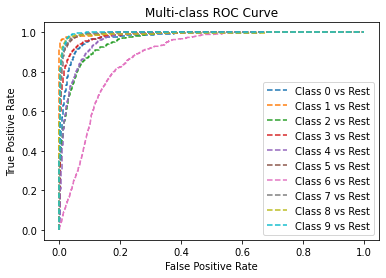

auc_score 0.9738060777777778


In [45]:
# ROC Curve:이것이 얼마나 decision boundary를 서서히 움직여 가면서 성능이 나오는지 확인
#acc만으로 성능이 잘 안나오는 경우가 있기 때문에 확인
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr = {}
tpr = {}
thresh = {}
n_class = 10

for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(test_labels_list, np.array(test_outputs_list)[:, i], pos_label=i)

# plot.
for i in range(n_class):
    plt.plot(fpr[i], tpr[i], linestyle="--", label=f"Class {i} vs Rest")
plt.title("Multi-class ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="best")
plt.show()

print("auc_score", roc_auc_score(test_labels_list, test_outputs_list, multi_class="ovo", average="macro"))